In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# 탐색적 데이터 분석

## 라이브러리 임포트

In [ ]:
# !pip install koreanize-matplotlib

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import numpy as np
import os
from collections import Counter

## 데이터 둘러보기 - 시각화
- 훈련 데이터 개수
- 테스트 데이터 개수
- 타겟값 분포

In [ ]:
data_path = "/content/drive/MyDrive/DMS/data/train_test_split_dataset"
train_data_path = os.path.join(data_path, "train_dataset")
test_data_path = os.path.join(data_path, "test_dataset")

In [ ]:
def get_data_distribution(data_path):
    """
    주어진 데이터 폴더에서 클래스별 샘플 개수를 계산하는 함수
    """
    label_counts = Counter()
    class_names = []

    # 폴더를 순회하며 데이터 개수 계산
    for label_dir in os.listdir(data_path):
        label_dirs_path = os.path.join(data_path, label_dir)

        if os.path.isdir(label_dirs_path):  # 디렉토리인지 확인
            class_name = label_dir.split("_")[0]  # 예: "normal_dmd" -> "normal"
            class_names.append(class_name)
            label_counts[class_name] += len(
                os.listdir(label_dirs_path)
            )  # 해당 폴더 내 샘플 개수

    return label_counts, sorted(set(class_names))  # (클래스별 샘플 개수, 클래스 리스트)

In [ ]:
def visualize_data_distribution(train_data_path, test_data_path):
    """
    훈련/테스트 데이터 개수 및 타겟값 분포를 시각화하는 함수
    """
    # 데이터 개수 확인
    train_label_counts, class_names = get_data_distribution(train_data_path)
    test_label_counts, _ = get_data_distribution(test_data_path)

    num_train = sum(train_label_counts.values())
    num_test = sum(test_label_counts.values())

    print(f"📌 훈련 데이터 개수: {num_train}")
    print(f"📌 테스트 데이터 개수: {num_test}")

    # 클래스별 개수 정렬
    train_counts_sorted = [train_label_counts[class_name] for class_name in class_names]
    test_counts_sorted = [test_label_counts[class_name] for class_name in class_names]

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # (왼쪽) Bar Chart - 클래스별 샘플 개수 비교
    x = np.arange(len(class_names))
    width = 0.4

    axes[0].bar(x - width / 2, train_counts_sorted, width, label="Train", alpha=0.7)
    axes[0].bar(x + width / 2, test_counts_sorted, width, label="Test", alpha=0.7)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_ylabel("샘플 개수")
    axes[0].set_title("클래스별 데이터 분포")
    axes[0].legend()

    # (오른쪽) Pie Chart - 전체 데이터 비율
    total_counts = np.array(
        [
            train_label_counts[class_name] + test_label_counts[class_name]
            for class_name in class_names
        ]
    )
    axes[1].pie(
        total_counts,
        labels=class_names,
        autopct="%1.1f%%",
        startangle=140,
        colors=plt.cm.Paired.colors,
    )
    axes[1].set_title("클래스별 전체 데이터 비율")

    plt.tight_layout()
    plt.show()

📌 훈련 데이터 개수: 8706
📌 테스트 데이터 개수: 1959


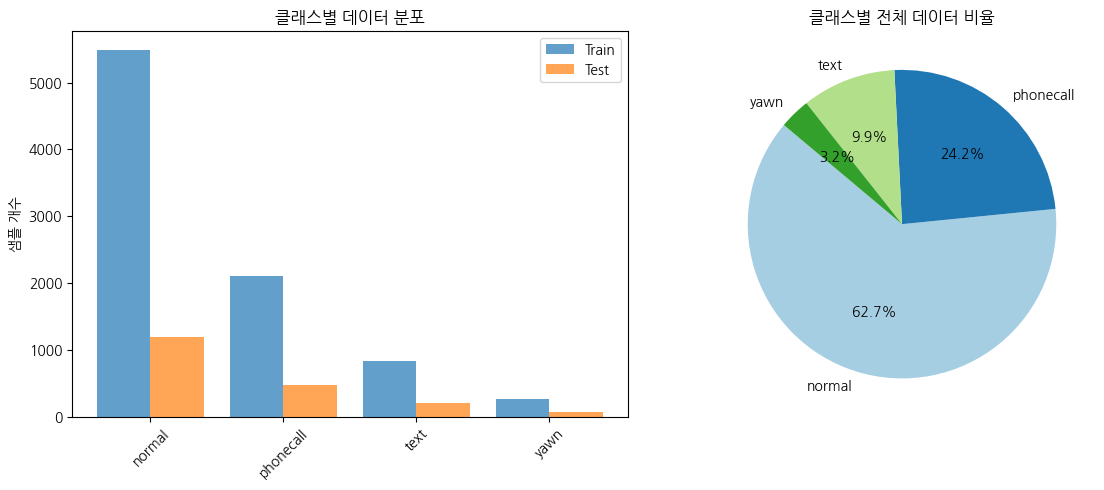

In [ ]:
visualize_data_distribution(train_data_path, test_data_path)

---
# 베이스라인 모델

## 라이브러리 임포트

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch.optim as optim
from PIL import Image

## 설정값 config

In [3]:
config = {
    # CNN 설정
    "CNN_fc_hidden1": 1024,  # 첫 번째 FC Layer 뉴런 개수
    "CNN_fc_hidden2": 768,  # 두 번째 FC Layer 뉴런 개수
    "CNN_embed_dim": 512,  # 2D CNN이 추출하는 특징 벡터 크기
    "res_size": 224,  # ResNet 입력 이미지 크기
    "dropout_p": 0.0,  # 드롭아웃 비율

    # RNN 설정
    "RNN_hidden_layers": 3,  # LSTM Layer 개수
    "RNN_hidden_nodes": 512,  # RNN Hidden State 크기
    "RNN_FC_dim": 256,  # RNN 최종 FC Layer 뉴런 개수

    # 학습 설정
    "k": 4,  # 클래스 개수 (normal, yawn, phonecall, text)
    "epochs": 15,  # 총 학습 횟수
    "batch_size": 64,  # 배치 크기
    "learning_rate": 5e-5,  # 학습률
    "log_interval": 5,  # 몇 번의 배치마다 로그 출력할지

    "action_names": ["normal", "yawn", "phonecall", "text"],  # 분류할 행동 리스트

    "use_cuda": torch.cuda.is_available(),
    "device": torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    ),  # GPU 사용 가능 여부에 따라 device 설정
    "early_stopping_patience": 5,  # Early Stopping 기준 Epoch
    "reduce_lr_factor": 0.5,  # Learning Rate 감소 비율
    "reduce_lr_patience": 3,  # Learning Rate 감소 기준 Epoch

    # 모델 결과 저장 경로
    "model_save_path": "/content/drive/MyDrive/DMS/ResNetCRNN_baseline_test_ckpt",
    "train_result_path": "/content/drive/MyDrive/DMS/ResNetCRNN_baseline_train_result_test",
}

## 데이터 준비

In [4]:
data_path = "/content/drive/MyDrive/DMS/data/train_test_split_dataset"
train_data_path = os.path.join(data_path, "train_dataset")
test_data_path = os.path.join(data_path, "test_dataset")

### 이미지 변환기

In [5]:
res_size = config["res_size"]  # ResNet 이미지 크기
transform = transforms.Compose(
    [
        transforms.Resize([res_size, res_size]),  # 이미지 크기 조정
        transforms.ToTensor(),  # 텐서 변환
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 정규화
    ]
)

### 데이터셋 클래스 정의

In [6]:
class Dataset_CRNN(data.Dataset):
    def __init__(self, data_path, folders, labels, transform=None):
        self.data_path = data_path
        self.labels = labels
        self.folders = folders
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def read_images(self, path, selected_folder, use_transform):
        X = []
        frame_files = sorted(
            [
                f
                for f in os.listdir(os.path.join(path, selected_folder))
                if f.endswith(".jpg")
            ]
        )

        for frame_filename in frame_files:
            frame_path = os.path.join(path, selected_folder, frame_filename)
            image = Image.open(frame_path)

            if use_transform is not None:
                image = use_transform(image)

            X.append(image)

        return torch.stack(X, dim=0)  # 모델 입력을 위해 텐서로 변환

    def __getitem__(self, index):
        folder = self.folders[index]
        X = self.read_images(self.data_path, folder, self.transform)
        y = torch.LongTensor([self.labels[index]])
        return X, y

### 데이터셋 생성

In [7]:
train_list, train_label = [], []
test_list, test_label = [], []

for label_dir in os.listdir(train_data_path):
    label_dirs_path = os.path.join(train_data_path, label_dir)
    label = label_dir.split("_")[0]

    for clipped_dirs in os.listdir(label_dirs_path):
        train_list.append(os.path.join("train_dataset", label_dir, clipped_dirs))
        train_label.append(label)

for label_dir in os.listdir(test_data_path):
    label_dirs_path = os.path.join(test_data_path, label_dir)
    label = label_dir.split("_")[0]

    for clipped_dirs in os.listdir(label_dirs_path):
        test_list.append(os.path.join("test_dataset", label_dir, clipped_dirs))
        test_label.append(label)

### Label Encoding

In [8]:
action_names = config["action_names"]
le = LabelEncoder()
le.fit(action_names)

train_label = le.transform(train_label)
test_label = le.transform(test_label)

### 데이터 로더 생성

In [9]:
train_set = Dataset_CRNN(data_path, train_list, train_label, transform)
test_set = Dataset_CRNN(data_path, test_list, test_label, transform)

In [10]:
params = (
    {
        "batch_size": config["batch_size"],
        "shuffle": True,  # 데이터 섞기
        "num_workers": 8,  # 데이터를 로드하는 프로세스 개수 (병렬 처리)
        "pin_memory": True,  # CUDA 사용 시 메모리 핀 설정으로 속도 향상
        "persistent_workers": True,  # worker 프로세스 유지하여 속도 증가
        "prefetch_factor": 4,  # 미리 데이터를 4배 더 로드하여 속도 향상
    }
    if config["use_cuda"]
    else {}
)

train_loader = data.DataLoader(train_set, **params)
test_loader = data.DataLoader(test_set, **params)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 모델 생성

### device 설정

In [11]:
device = config["device"]

### ResCNNEncoder 모델 정의

In [12]:
class ResCNNEncoder(nn.Module):
    def __init__(self, fc_hidden1=512, fc_hidden2=512, drop_p=0.3, CNN_embed_dim=300):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(ResCNNEncoder, self).__init__()

        self.fc_hidden1, self.fc_hidden2 = fc_hidden1, fc_hidden2
        self.drop_p = drop_p

        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]  # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, fc_hidden1)
        self.bn1 = nn.BatchNorm1d(fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(fc_hidden1, fc_hidden2)
        self.bn2 = nn.BatchNorm1d(fc_hidden2, momentum=0.01)
        self.fc3 = nn.Linear(fc_hidden2, CNN_embed_dim)

    def forward(self, x_3d):
        cnn_embed_seq = []
        for t in range(x_3d.size(1)):
            # ResNet CNN
            with torch.no_grad():
                x = self.resnet(x_3d[:, t, :, :, :])  # ResNet
                x = x.view(x.size(0), -1)  # flatten output of conv

            # FC layers
            x = self.bn1(self.fc1(x))
            x = F.relu(x)
            x = self.bn2(self.fc2(x))
            x = F.relu(x)
            x = F.dropout(x, p=self.drop_p, training=self.training)
            x = self.fc3(x)

            cnn_embed_seq.append(x)

        # swap time and sample dim such that (sample dim, time dim, CNN latent dim)
        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0).transpose_(0, 1)
        # cnn_embed_seq: shape=(batch, time_step, input_size)

        return cnn_embed_seq

### DecoderRNN 모델 정의

In [13]:
class DecoderRNN(nn.Module):
    def __init__(
        self,
        CNN_embed_dim=300,
        h_RNN_layers=3,
        h_RNN=256,
        h_FC_dim=128,
        drop_p=0.3,
        num_classes=50,
    ):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = CNN_embed_dim
        self.h_RNN_layers = h_RNN_layers  # RNN hidden layers
        self.h_RNN = h_RNN  # RNN hidden nodes
        self.h_FC_dim = h_FC_dim
        self.drop_p = drop_p
        self.num_classes = num_classes

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=h_RNN_layers,
            batch_first=True,  # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)

    def forward(self, x_RNN):

        self.LSTM.flatten_parameters()
        RNN_out, (h_n, h_c) = self.LSTM(x_RNN, None)
        """ h_n shape (n_layers, batch, hidden_size), h_c shape (n_layers, batch, hidden_size) """
        """ None represents zero initial hidden state. RNN_out has shape=(batch, time_step, output_size) """

        # FC layers
        x = self.fc1(RNN_out[:, -1, :])  # choose RNN_out at the last time step
        x = F.relu(x)
        x = F.dropout(x, p=self.drop_p, training=self.training)
        x = self.fc2(x)

        return x

### 모델 생성

In [14]:
cnn_encoder = ResCNNEncoder(
    fc_hidden1=config["CNN_fc_hidden1"],
    fc_hidden2=config["CNN_fc_hidden2"],
    drop_p=config["dropout_p"],
    CNN_embed_dim=config["CNN_embed_dim"],
).to(device)
rnn_decoder = DecoderRNN(
    CNN_embed_dim=config["CNN_embed_dim"],
    h_RNN_layers=config["RNN_hidden_layers"],
    h_RNN=config["RNN_hidden_nodes"],
    h_FC_dim=config["RNN_FC_dim"],
    drop_p=config["dropout_p"],
    num_classes=config["k"],
).to(device)

model = [cnn_encoder, rnn_decoder]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 156MB/s]


### 멀티 GPU 병렬 처리

In [15]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    cnn_encoder = nn.DataParallel(cnn_encoder)
    rnn_decoder = nn.DataParallel(rnn_decoder)
    crnn_params = (
        list(cnn_encoder.module.fc1.parameters())
        + list(cnn_encoder.module.bn1.parameters())
        + list(cnn_encoder.module.fc2.parameters())
        + list(cnn_encoder.module.bn2.parameters())
        + list(cnn_encoder.module.fc3.parameters())
        + list(rnn_decoder.parameters())
    )
else:
    print(f"Using {torch.cuda.device_count()} GPU!")
    crnn_params = (
        list(cnn_encoder.fc1.parameters())
        + list(cnn_encoder.bn1.parameters())
        + list(cnn_encoder.fc2.parameters())
        + list(cnn_encoder.bn2.parameters())
        + list(cnn_encoder.fc3.parameters())
        + list(rnn_decoder.parameters())
    )

Using 1 GPU!


## 모델 훈련 및 성능 검증

### 옵티마이저 설정

In [16]:
optimizer = torch.optim.Adam(crnn_params, lr=config["learning_rate"])

### 손실 함수 설정

In [17]:
criterion = nn.CrossEntropyLoss()

### 학습률 감소 스케줄러 설정
Test Loss 기준
- factor: 0.5, 학습률 50% 감소
- verbose: True, 감소된 경우 로그 출력

In [19]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=config["reduce_lr_factor"],
    patience=config["reduce_lr_patience"],
    verbose=True,
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Early Stopping 설정

In [20]:
early_stopping_patience = config["early_stopping_patience"]
best_loss = np.inf
patience_counter = 0

### 학습 진행

#### train 함수

In [21]:
scaler = torch.amp.GradScaler()


def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    cnn_encoder, rnn_decoder = model
    cnn_encoder.train()
    rnn_decoder.train()

    losses, scores = [], []
    total_samples = 0

    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device).view(
            -1,
        )

        # Mixed Precision Training 적용
        total_samples += X.size(0)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda"):
            output = rnn_decoder(cnn_encoder(X))
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())

        # 정확도 계산
        y_pred = torch.max(output, 1)[1]
        acc = accuracy_score(
            y.cpu().data.squeeze().numpy(),
            y_pred.cpu().data.squeeze().numpy(),
        )
        scores.append(acc)

        # 로그 출력
        if (batch_idx + 1) % log_interval == 0:
            print(
                f"Train Epoch: {epoch + 1} [{total_samples}/{len(train_loader.dataset)} "
                f"({100.0 * (batch_idx + 1) / len(train_loader):.0f}%)]\t"
                f"Loss: {loss.item():.6f}, Acc: {100 * acc:.2f}%"
            )

    return losses, scores

#### validate 함수

In [22]:
def validate(
    model, device, criterion, test_loader, save_model_path=None, optimizer=None
):
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    test_loss, all_y, all_y_pred = 0, [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device).view(
                -1,
            )

            with torch.amp.autocast("cuda"):
                output = rnn_decoder(cnn_encoder(X))
                loss = criterion(output, y)

            test_loss += loss.item()
            y_pred = output.max(1, keepdim=True)[1]

            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(
        all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy()
    )

    # 로그 출력
    print(
        f"\nTest set ({len(all_y)} samples): Average loss: {test_loss:.4f}, Accuracy: {100 * test_score:.2f}%\n"
    )

    # 모델 저장 기능(옵셔널)
    if save_model_path and optimizer:
        save_model(cnn_encoder, rnn_decoder, optimizer, epoch, save_model_path)

    return test_loss, test_score

#### 모델 저장 함수

In [23]:
def save_model(cnn_encoder, rnn_decoder, optimizer, epoch, save_model_path):
    """
    모델 및 옵티마이저 상태 저장 함수
    """
    os.makedirs(save_model_path, exist_ok=True)

    torch.save(
        cnn_encoder.state_dict(),
        os.path.join(save_model_path, f"cnn_encoder_epoch{epoch + 1}.pth"),
    )
    torch.save(
        rnn_decoder.state_dict(),
        os.path.join(save_model_path, f"rnn_decoder_epoch{epoch + 1}.pth"),
    )
    torch.save(
        optimizer.state_dict(),
        os.path.join(save_model_path, f"optimizer_epoch{epoch + 1}.pth"),
    )

    print(f"✅ Epoch {epoch + 1} 모델 저장 완료\n")

#### 학습 결과 저장 함수

In [24]:
def save_training_results(
    epoch,
    epoch_train_losses,
    epoch_train_scores,
    epoch_test_losses,
    epoch_test_scores,
    save_path="./",
):
    """
    학습 과정의 손실(loss)과 정확도(score)를 저장하는 함수
    """
    os.makedirs(save_path, exist_ok=True)

    np.save(
        os.path.join(save_path, "CRNN_epoch_training_losses.npy"),
        np.array(epoch_train_losses),
    )
    np.save(
        os.path.join(save_path, "CRNN_epoch_tsave_path, raining_scores.npy"),
        np.array(epoch_train_scores),
    )
    np.save(
        os.path.join(save_path, "CRNN_epoch_test_loss.npy"), np.array(epoch_test_losses)
    )
    np.save(
        os.path.join(save_path, "CRNN_epoch_test_score.npy"),
        np.array(epoch_test_scores),
    )

    print(f"✅ Epoch {epoch+1} 학습 결과 저장 완료\n")

#### train & validate & 모델 저장 & 학습 결과 저장

In [ ]:
epoch_train_losses, epoch_train_scores = [], []
epoch_test_losses, epoch_test_scores = [], []

for epoch in range(config["epochs"]):
    epoch_train_loss, epoch_train_score = train(
        config["log_interval"], model, device, train_loader, optimizer, criterion, epoch
    )

    epoch_test_loss, epoch_test_score = validate(
        model, device, criterion, test_loader, config["model_save_path"], optimizer
    )

    epoch_train_losses.append(epoch_train_loss)
    epoch_train_scores.append(epoch_train_score)
    epoch_test_losses.append(epoch_test_loss)
    epoch_test_scores.append(epoch_test_score)

    # 학습률 감소 적용
    scheduler.step(epoch_test_loss)

    # Early Stopping 체크
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        patience_counter = 0  # 개선되었으므로 patience 초기화
    else:
        patience_counter += 1  # 개선되지 않으면 patience 증가
        print(
            f"⏳ Early stopping 대기 카운트: {patience_counter}/{early_stopping_patience}"
        )

    # 설정된 patience 횟수만큼 개선되지 않으면 학습 중단
    if patience_counter >= early_stopping_patience:
        print("⏹️ Early stopping 적용됨. 학습 종료.")
        break  # 학습 중단

    # 학습 결과 저장
    save_training_results(
        epoch,
        epoch_train_losses,
        epoch_train_scores,
        epoch_test_losses,
        epoch_test_scores,
        save_path=config["train_result_path"],
    )

Train Epoch: 1 [320/8706 (4%)]	Loss: 1.357391, Acc: 67.19%


## 결과 시각화

In [ ]:
def plot_training_results(
    epochs,
    epoch_train_losses,
    epoch_train_scores,
    epoch_test_losses,
    epoch_test_scores,
    save_path="./",
):
    """
    학습 과정의 Loss 및 Accuracy를 시각화하는 함수
    """
    os.makedirs(save_path, exist_ok=True)

    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)

    fig = plt.figure(figsize=(10, 4))

    # Loss 그래프
    plt.subplot(121)
    plt.plot(np.arange(1, epochs + 1), A.mean(axis=1))  # train loss(각 에포크의 평균)
    plt.plot(np.arange(1, epochs + 1), C)  # test loss
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train", "Test"], loc="upper left")

    # Accuracy 그래프
    plt.subplot(122)
    plt.plot(
        np.arange(1, epochs + 1), B.mean(axis=1)
    )  # train accuracy (각 에포크의 평균)
    plt.plot(np.arange(1, epochs + 1), D)  # test accuracy
    plt.title("Training Scores")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Test"], loc="upper left")

    # 그래프 저장
    plot_save_path = os.path.join(save_path, "training_results.png")
    plt.savefig(plot_save_path, dpi=600)
    plt.show()

    print(f"\n✅ 학습 그래프 저장 완료 ({plot_save_path})\n")

In [ ]:
plot_training_results(
    config["epochs"],
    epoch_train_losses,
    epoch_train_scores,
    epoch_test_losses,
    epoch_test_scores,
    save_path=config["train_result_path"],
)